# disc impulse response function

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
from scipy.special import jv, jvp, jn_zeros

import matplotlib.pyplot as plt

In [2]:
def compute_response(a, k, Tb, r, t, n):
    """ Compute the step response of a disc to temperature at the boundary
    Parameters
    ----------
    a: float
        disc radius
    k: float
        diffusivity coefficient
    Tb: float
        temperature step amplitude
    r: np.array
        radius where to compute the solution
    t: np.array
        time where to compute the solution
    n: int
        number of bessel functions to consider
    """

    ds = xr.Dataset(
        None,
        coords=dict(r=r, mode=np.arange(1,n+1), time=t)
    )
    
    # start building up solution
    ds["zeros"] = ("mode", jn_zeros(0, n))
    ds["lambda"] = ds["zeros"]/a
    ds["I0p"] = jvp(0, a * ds["lambda"])
    ds["Tn"] = 2/a/ds["lambda"]/ds["I0p"]
    
    ds["T_transient"] = Tb * (
        (
            ds["Tn"] 
            * jv(0, ds["lambda"]*ds["r"])
            * np.exp(-k * ds["lambda"]**2 * ds["time"])
        ).sum("mode")
    )
    ds["T"] = Tb + ds["T_transient"]
    
    ds["dT/dt"] = ds["T"].differentiate("time")

    return ds

In [3]:
a = 1 # disc radius
k = 1 # diffusion coefficient
Tb = 1 # step amplitude

r = np.linspace(0, a, 100)
T = np.sqrt(a/k)
t = np.arange(T/200,T,T/100)

ds10 = compute_response(a, k, Tb, r, t, 10)
ds5 = compute_response(a, k, Tb, r, t, 5)
ds2 = compute_response(a, k, Tb, r, t, 2)
ds1 = compute_response(a, k, Tb, r, t, 1)

Text(0.5, 1.0, 'impulse response function at center of disc')

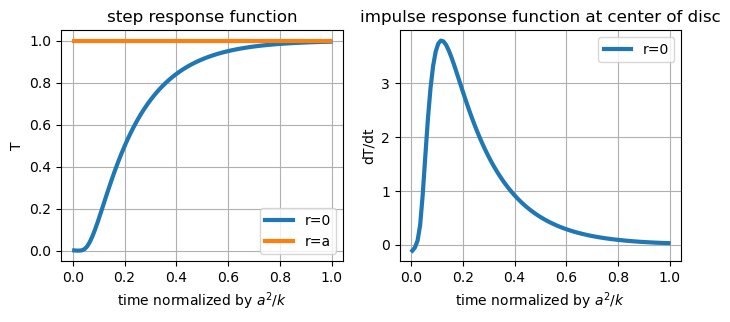

In [4]:
ds = ds10

fig, axes = plt.subplots(1,2, figsize=(8,3))
ax = axes[0]
ds["T"].sel(r=0).plot(ax=ax, lw=3, label="r=0")
ds["T"].sel(r=a, method='nearest').plot(ax=ax, lw=3, label="r=a")
ax.legend()
ax.grid()
ax.set_xlabel(r"time normalized by $a^2/k$")
ax.set_title("step response function")

ax = axes[1]
ds["dT/dt"].sel(r=0).plot(ax=ax, lw=3, label="r=0")
ax.legend()
ax.grid()
ax.set_xlabel(r"time normalized by $a^2/k$")
ax.set_title("impulse response function at center of disc")

### sensitivity to the number of bessels added

Text(0.5, 1.0, 'impulse response function at center of disc')

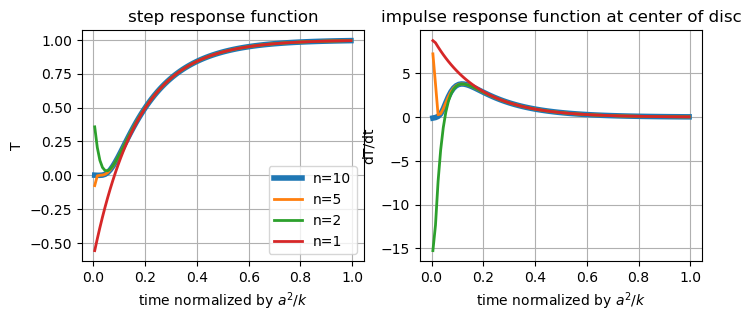

In [5]:
fig, axes = plt.subplots(1,2, figsize=(8,3))
ax = axes[0]
ds10["T"].sel(r=0).plot(ax=ax, lw=4, label="n=10")
ds5["T"].sel(r=0).plot(ax=ax, lw=2, label="n=5")
ds2["T"].sel(r=0).plot(ax=ax, lw=2, label="n=2")
ds1["T"].sel(r=0).plot(ax=ax, lw=2, label="n=1")
ax.legend()
ax.grid()
ax.set_xlabel(r"time normalized by $a^2/k$")
ax.set_title("step response function")

ax = axes[1]
ds10["dT/dt"].sel(r=0).plot(ax=ax, lw=4, label="n=10")
ds5["dT/dt"].sel(r=0).plot(ax=ax, lw=2, label="n=5")
ds2["dT/dt"].sel(r=0).plot(ax=ax, lw=2, label="n=2")
ds1["dT/dt"].sel(r=0).plot(ax=ax, lw=2, label="n=2")
#ax.legend()
ax.grid()
ax.set_xlabel(r"time normalized by $a^2/k$")
ax.set_title("impulse response function at center of disc")

In [7]:
a = 0.05
t = 3600
k = a**2/t * 0.1
k

6.944444444444447e-08